# Mode Selection

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by providing a trajectory to the ModeSelector module and obtaining only strongly-contributing modes.

### Mode selection by power contribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux
from few.amplitude.ampinterp2d import AmpInterpSchwarzEcc
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector

# tune few configuration
cfg_set = few.get_config_setter(reset=True)

# Uncomment if you want to force CPU or GPU usage
# Leave commented to let FEW automatically select the best available hardware
#   - To force CPU usage:
# cfg_set.enable_backends("cpu")
#   - To force GPU usage with CUDA 12.x
# cfg_set.enable_backends("cuda12x", "cpu")
#   - To force GPU usage with CUDA 11.x
# cfg_set.enable_backends("cuda11x", "cpu")

cfg_set.set_log_level("info");

In [5]:
# first, lets get amplitudes for a trajectory
traj = EMRIInspiral(func=SchwarzEccFlux)

# parameters
m1 = 1e5
m2 = 1e1
a = 0.0 # Schwarzschild
p0 = 10.0
e0 = 0.7
theta = np.pi / 3.0
phi = np.pi / 2.0

t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(m1, m2, 0.0, p0, e0, 1.0)

amp_module = AmpInterpSchwarzEcc()
ylm_gen = GetYlms()

# select modes

mode_selector = ModeSelector(
    amp_module,
    ylm_generator=ylm_gen,  # optional, this is the default choice
    force_backend="cpu"
)

mode_selection_threshold = 1e-2  # target mismatch between reduced and full mode content waveforms

(teuk_modes_r, ylms_r, ls_r, ms_r, ks_r, ns_r) = mode_selector(
    t,
    a, 
    p, 
    e, 
    x, 
    theta, 
    phi, 
    mode_selection_threshold=mode_selection_threshold  # this can also be provided to ModeSelector() on instantiation
)

(teuk_modes, ylms, ls, ms, ks, ns) = mode_selector(
    t,
    a, 
    p, 
    e, 
    x, 
    theta, 
    phi, 
    mode_selection = "all",  # this can also be provided to ModeSelector() on instantiation
)

print(
    "We reduced the mode content from {} modes to {} modes.".format(
        teuk_modes.shape[1], teuk_modes_r.shape[1]
    )
)

We reduced the mode content from 3843 modes to 59 modes.


### Mode selection by noise-weighted power contribution

Modes can also be weighted by a Power Spectral Density (PSD) function from your favorite sensitivity curve. This ensures that the target mismatch is with respect to the PSD that will be used in (for example) parameter estimation. 

(CubicSplineInterpolant) Warning: New t array outside bounds of input t array. These points are filled with edge values.


We reduced the mode content from 3843 modes to 40 modes when using noise-weighting.


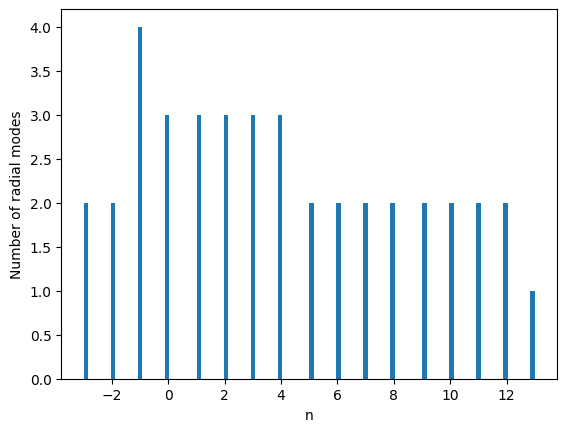

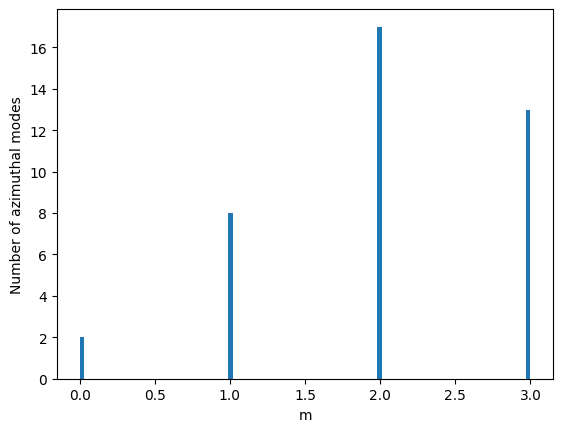

In [10]:
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

# produce sensitivity function
noise = np.genfromtxt(get_file_manager().get_file("LPA.txt"), names=True)  # LISA PSD
f, PSD = (
    np.asarray(noise["f"], dtype=np.float64),
    np.asarray(noise["ASD"], dtype=np.float64) ** 2,
)

sens_fn = CubicSplineInterpolant(f, PSD)

# select modes with noise weighting

# provide sensitivity function kwarg
mode_selector_noise_weighted = ModeSelector(
    amp_module, 
    ylm_generator=ylm_gen,  # optional, this is the default choice
    sensitivity_fn=sens_fn
)


# we need the orbital frequencies when noise-weighting
# these can be computed from the trajectory output efficiently

freqs = traj.inspiral_generator.eval_integrator_derivative_spline(t, order=1)[:,3:6] / 2 / np.pi

online_mode_selection_args = dict(
    f_phi = freqs[:,0],
    f_theta = freqs[:,1],
    f_r = freqs[:,2],
)

(teuk_modes_r_nw, ylms_r_nw, ls_r_nw, ms_r_nw, ks_r_nw, ns_r_nw) = mode_selector_noise_weighted(
    t,
    a, 
    p, 
    e, 
    x, 
    theta, 
    phi,
    online_mode_selection_args=online_mode_selection_args,
    mode_selection_threshold=mode_selection_threshold  # this can also be provided to ModeSelector() on instantiation
)

print(
    "We reduced the mode content from {} modes to {} modes when using noise-weighting.".format(
        teuk_modes.shape[1], teuk_modes_r_nw.shape[1]
    )
)
# plot histogram of modes
plt.figure()
plt.hist(ns_r_nw, bins=100, label="n")
plt.xlabel("n")
plt.ylabel("Number of radial modes")
plt.show()

plt.figure()
plt.hist(ms_r_nw, bins=100, label="n")
plt.xlabel("m")
plt.ylabel("Number of azimuthal modes")
plt.show()

### Compare the two waves with and without noise-weighting

(CubicSplineInterpolant) Warning: New t array outside bounds of input t array. These points are filled with edge values.


mismatch: 0.013279647101797742
base modes: 12
noise-weighted modes: 17


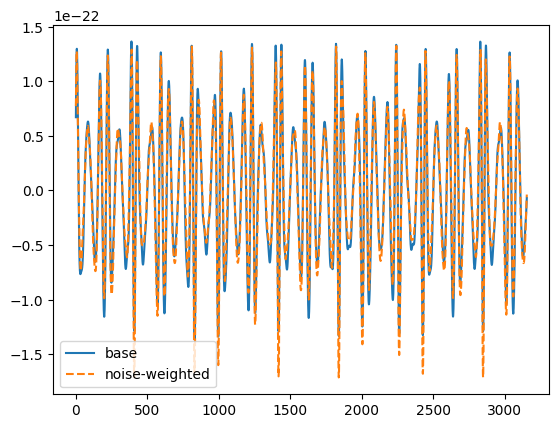

In [12]:
from few.waveform import FastSchwarzschildEccentricFluxBicubic
from few.utils.utility import get_mismatch


noise_weighted_mode_selector_kwargs = dict(sensitivity_fn=sens_fn)

inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
}

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "include_minus_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "pad_output": False,
}

few_base = FastSchwarzschildEccentricFluxBicubic(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
)

few_noise_weighted = FastSchwarzschildEccentricFluxBicubic(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    mode_selector_kwargs=noise_weighted_mode_selector_kwargs,
)

m1 = 1e6
m2 = 1e1
p0 = 12.0
e0 = 0.3
theta = np.pi / 3.0
phi = np.pi / 4.0
dist = 1.0
dt = 10.0
T = 0.001

wave_base = few_base(m1, m2, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection_threshold=1e-2)
wave_weighted = few_noise_weighted(
    m1, m2, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection_threshold=1e-2
)

plt.plot(wave_base.real, label="base")
plt.plot(wave_weighted.real, ls='--', label="noise-weighted")
plt.legend()
print("mismatch:", get_mismatch(wave_base, wave_weighted))
print("base modes:", few_base.num_modes_kept)
print("noise-weighted modes:", few_noise_weighted.num_modes_kept)

### Specific mode selection

The user can also select a specific set of modes to use in the waveform.

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


mismatch with full wave: 0.04028675533275361


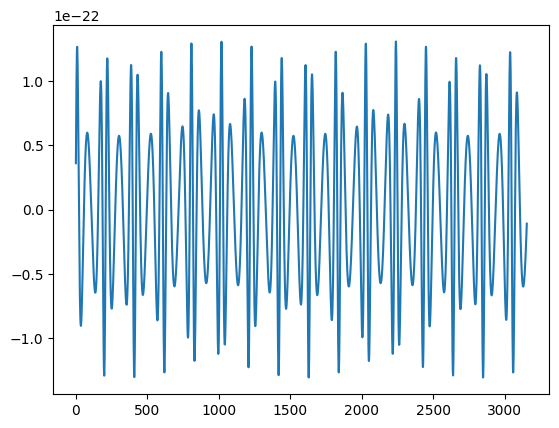

In [13]:
# l = 2, m = 2 wave
specific_modes = [(2, 2, 0, n) for n in range(-30, 31)]

wave_22 = few_base(
    m1, m2, p0, e0, theta, phi, dist=dist, dt=dt, T=T, mode_selection=specific_modes
)

plt.plot(wave_22.real)

print("mismatch with full wave:", get_mismatch(wave_22, wave_base))

### Turn off $(-m, -k, -n)$ modes

By default, symmetry is used to generate $(-m, -k, -n)$ modes from their corresponding $(m, k, n)$ counterparts. To disable this behaviour, provide `False` to the `include_minus_mkn` kwarg. This only affects the waveform when `mode_selection` is a list of specific modes. 

As some checks are performed on `mode_selection` during waveform evaluation, if the same mode content for many waveforms is required, it can be more efficient to provide this list of modes to `mode_selector_kwargs` when instantiating the waveform generator object.

(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.
(ModeSelector) Warning: Mode selection is large. Instantiate class with mode selection rather than providing it at call time for better performance.


mismatch with 22 wave with + and - m: 2.0
mismatch with 22 original wave with adding + and - m 0.00611440523611162


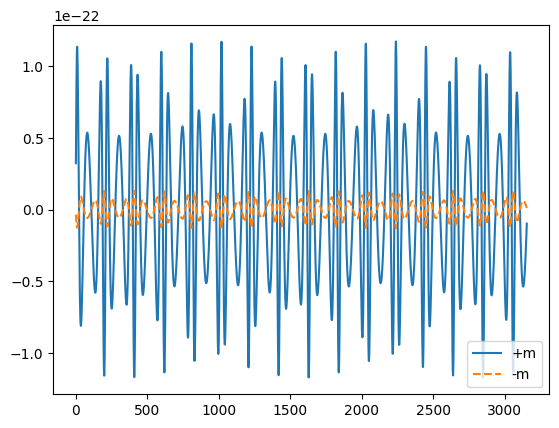

In [14]:
%matplotlib inline
# l = 2, m = 2 wave without m = -2
specific_modes = [(2, 2, 0, n) for n in range(-30, 31)]

specific_modes_minus_m = [(2, -2, 0, n) for n in range(-30, 31)]

wave_22_pos_m = few_base(
    m1,
    m2,
    p0,
    e0,
    theta,
    phi,
    dist=dist,
    dt=dt,
    T=0.001,
    mode_selection=specific_modes,
    include_minus_mkn=False,
)

wave_22_minus_m = few_base(
    m1,
    m2,
    p0,
    e0,
    theta,
    phi,
    dist=dist,
    dt=dt,
    T=0.001,
    mode_selection=specific_modes_minus_m,
    include_minus_mkn=False,
)

plt.plot(wave_22_pos_m.real, label="+m")
plt.plot(wave_22_minus_m.real, label="-m", ls="--")
plt.legend()
print(
    "mismatch with 22 wave with + and - m:",
    get_mismatch(wave_22_minus_m, wave_22_pos_m),
)

print(
    "mismatch with 22 original wave with adding + and - m",
    get_mismatch(wave_22, wave_22_pos_m + wave_22_minus_m),
)